### Wakefield simulation of accelerator cavity with `wakis`

* EM Simulation of a lossy cylindrical accelerator cavity up to a partially decayed wake
* Calculation of the longitudinal wake potential and impedance of partially decayed and:
    * Partially decayed to fully decayed impedance with [IDDEFIX](https://github.com/ImpedanCEI/IDDEFIX) Differential Evolution algorithm
    * Extrapolation of partially decayed wake to fully decayed with [IDDEFIX](https://github.com/ImpedanCEI/IDDEFIX) Resonator formalism
* Plotting of the results

In [1]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

from wakis import SolverFIT3D
from wakis import GridFIT3D 
from wakis import WakeSolver

%matplotlib ipympl
pv.set_jupyter_backend('client')

### Domain setup and grid generation

Wakis will import the geometry files stored in `.stl` format and generate a grid with the number of mesh cells selected by the user `Nx`, `Ny`, `Nz`. The same geometry as example `002_Wakefield_simulation.ipynb` will be used, and futher details on the simulation and visualization can be found there.

In [2]:
# ---------- Domain setup ---------
# Read geometry -change path if errors are found!
stl_cavity = 'notebooks/data/002_vacuum_cavity.stl' 
stl_shell = 'notebooks/data/002_lossymetal_shell.stl'

# Set up geometry & materials dictionaries
stl_solids = {'cavity': stl_cavity, 'shell': stl_shell}
stl_materials = {'cavity': 'vacuum', 'shell': [30, 1.0, 30]}

# Domain bounds
surf = pv.read(stl_shell) + pv.read(stl_cavity)
xmin, xmax, ymin, ymax, zmin, zmax = surf.bounds
Lx, Ly, Lz = (xmax-xmin), (ymax-ymin), (zmax-zmin)

# Number of mesh cells
Nx = 80
Ny = 80
Nz = 161

# set grid and geometry
grid = GridFIT3D(xmin, xmax, ymin, ymax, zmin, zmax, Nx, Ny, Nz, 
                stl_solids=stl_solids, 
                stl_materials=stl_materials,
                stl_scale=1.0)

Generating grid...
Importing STL solids...


In [3]:
if False:
    grid.plot_solids(bounding_box=True)

### Boundary conditions and EM solver

In [4]:
# boundary conditions
bc_low=['pec', 'pec', 'pml']
bc_high=['pec', 'pec', 'pml']

n_pml = 10 # number of PML layers
solver = SolverFIT3D(grid, 
                     bc_low=bc_low, bc_high=bc_high, 
                     use_stl=True, bg='pec',
                     n_pml=n_pml)

Assembling operator matrices...
Applying boundary conditions...
Adding material tensors...
Filling PML sigmas...
Calculating maximal stable timestep...
Pre-computing...
Total initialization time: 1.3350105285644531 s


### Wakefield settings & Run

The wakefield simulation will run up to 10 m which will give a partially decayed wake and a non-converged impedance - this will be the starting point of IDDEFIX extrapolation !

In [5]:
# ------------ Beam source ----------------
# Beam parameters
sigmaz = 10e-2      #[m] -> 2 GHz
q = 1e-9            #[C]
beta = 1.0          # beam beta 
xs = 0.             # x source position [m]
ys = 0.             # y source position [m]
xt = 0.             # x test position [m]
yt = 0.             # y test position [m]
# [DEFAULT] tinj = 8.53*sigmaz/c_light  # injection time offset [s] 


# ----------- Solver  setup  ----------
# Wakefield post-processor
wakelength = 10. # [m] -> Partially decayed
skip_cells = n_pml + 2  # no. cells to skip from wake integration (>= PML cells)

wake = WakeSolver(q=q, sigmaz=sigmaz, beta=beta,
                xsource=xs, ysource=ys, xtest=xt, ytest=yt,
                skip_cells=skip_cells, wakelength=wakelength,
                results_folder='notebooks/004_results/',
                Ez_file='notebooks/004_results/Ez.h5',)

The cell bellow will run the wakefield simulation with the defined beam source and wakelength 

In [6]:
if False:
    solver.wakesolve(wakelength=wakelength, 
                    wake=wake, 
                    plot=False)

Or, if results have already been generated:

In [7]:
wake.load_results("notebooks/004_results")

It's done! Now we can plot the results:

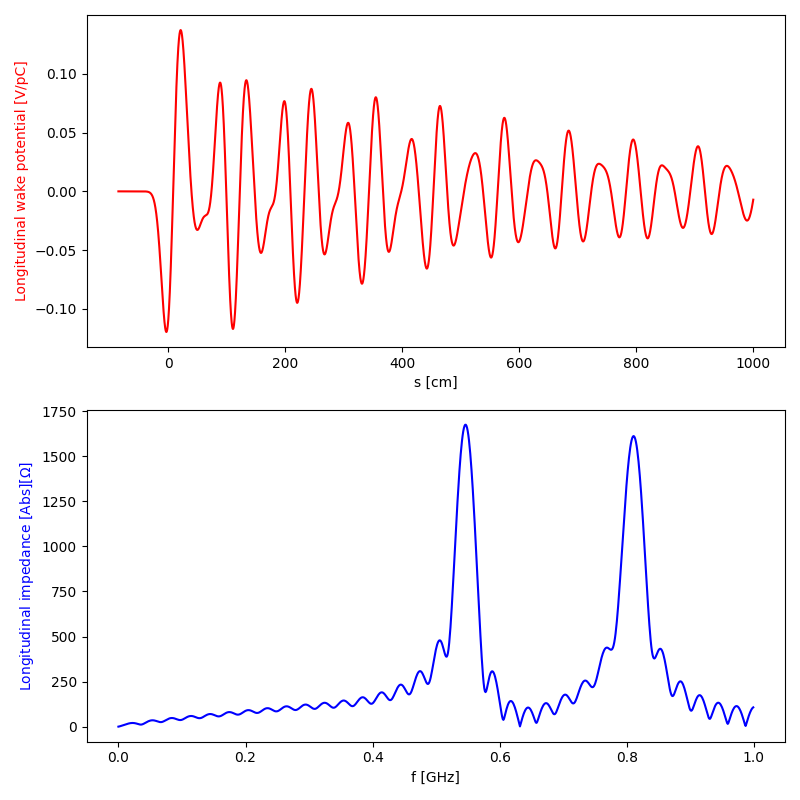

In [8]:
fig, ax = plt.subplots(2,1, figsize=[8,8], dpi=100)
ax[0].plot(wake.s*1e2, wake.WP, c='r', lw=1.5, label='Wakis')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='r')

ax[1].plot(wake.f*1e-9, np.abs(wake.Z), c='b', lw=1.5, label='Wakis')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='b')

fig.tight_layout()

## Partial to Fully decayed impedance with IDDEFIX

The [IDDEFIX](https://github.com/ImpedanCEI/IDDEFIX) (Impedance Determination through Differential Evolution FItting and eXtrapolation) python package will take the partially decayed wake and give back the fully decayed wake using the **Resonator formalism** and **Diferential Evolution's** algorithms powered with `scipy` and `pymoo`

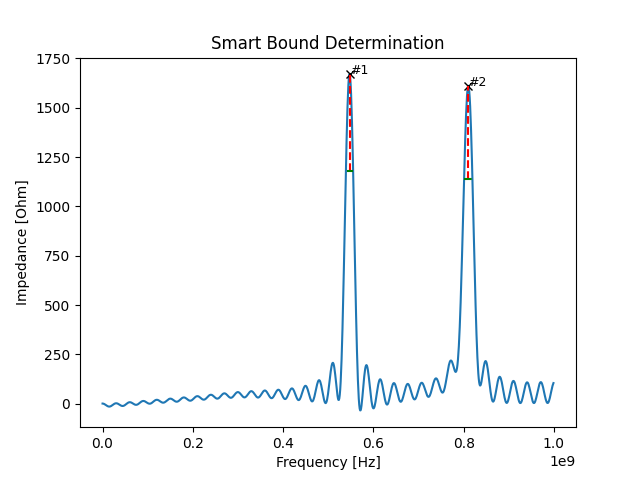


--------------------------------------------------------------------------------
Resonator |   Rs [Ohm/m or Ohm]    |        Q         |        fres [Hz]        
--------------------------------------------------------------------------------
    1     |  1334.96 to 16687.05   | 19.50 to 195.00  |  5.38e+08 to 5.58e+08   
    2     |  1288.76 to 16109.55   | 22.44 to 224.44  |  8.00e+08 to 8.20e+08   
--------------------------------------------------------------------------------


In [9]:
# get bounds for the Differential Evolution fitting
bounds = wake.get_SmartBounds(freq_data=wake.f, impedance_data=wake.Z,
                        minimum_peak_height=500, distance=3, inspect_bounds=True,
                        Rs_bounds=[0.8, 10], Q_bounds=[0.5, 5], fres_bounds=[-0.01e9, +0.01e9]
                        )

In [10]:
wake.wakelength

10.0

In [ ]:
DE_model = wake.get_DEmodel_fitting(freq_data=wake.f, impedance_data=wake.Z, 
                                    plane='longitudinal', dim='z', 
                                    parameterBounds=bounds.parameterBounds, N_resonators=bounds.N_resonators, 
                                    DE_kernel='DE', maxiter=1e5, cmaes_sigma=0.01, popsize=150, tol=1e-3,
                                    use_minimization=True, minimization_margin=[0.3, 0.2, 0.01])

Fitting the impedance using Differential Evolution...
[!] Using the partially decayed resonator formalism for impedance
[(1334.9643724470197, 16687.054655587744), (19.500000000000014, 195.00000000000014), (537619999.4536437, 557619999.4536437), (1288.7641147415088, 16109.551434268858), (22.444444444444418, 224.44444444444417), (800397361.8288354, 820397361.8288354)]
<function ObjectiveFunctions.sumOfSquaredErrorReal at 0x7405bb5a07c0>


UnboundLocalError: cannot access local variable 'Problem' where it is not associated with a value

### Plot the extrapolation result

In [15]:
from scipy.constants import c as c_light
s, wake_potential = wake.get_extrapolated_wake(wakelength=100, sigma=sigmaz/c_light, use_minimization=True)
t, wake_function = wake.get_extrapolated_wake_function(wakelength=100, use_minimization=True)
f, impedance = wake.get_extrapolated_impedance(wakelength=100, use_minimization=True)

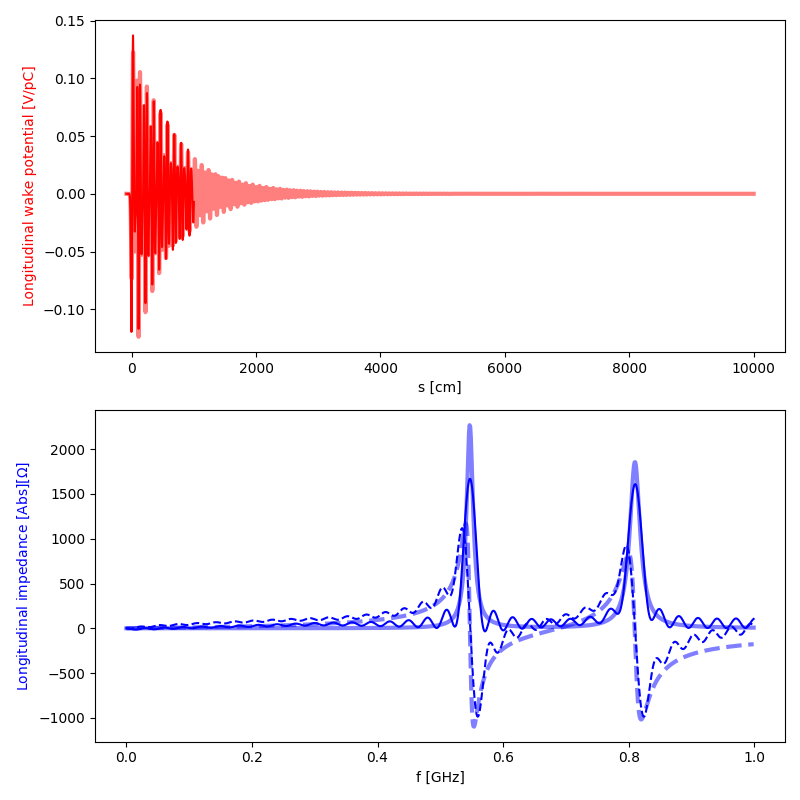

In [16]:

fig, ax = plt.subplots(2,1, figsize=[8,8], dpi=100)
ax[0].plot(wake.s*1e2, wake.WP, c='r', lw=1.5, label='Wakis')
ax[0].plot(s*1e2, wake_potential, c='r', lw=3, alpha=0.5, label='Wakis DE extrapolation')
ax[0].set_xlabel('s [cm]')
ax[0].set_ylabel('Longitudinal wake potential [V/pC]', color='r')

ax[1].plot(wake.f*1e-9, np.real(wake.Z), c='b', lw=1.5, label='Wakis - Re')
ax[1].plot(wake.f*1e-9, np.imag(wake.Z), c='b', lw=1.5, ls='--', label='Wakis - Imag')

ax[1].plot(f*1e-9, np.real(impedance), c='b', lw=3, alpha=0.5, label='Wakis DE - Re')
ax[1].plot(f*1e-9, np.imag(impedance), c='b', lw=3, ls='--', alpha=0.5, label='Wakis DE - Imag')
ax[1].set_xlabel('f [GHz]')
ax[1].set_ylabel('Longitudinal impedance [Abs][$\Omega$]', color='b')

fig.tight_layout()

### Extra: Assess the DE fitting 

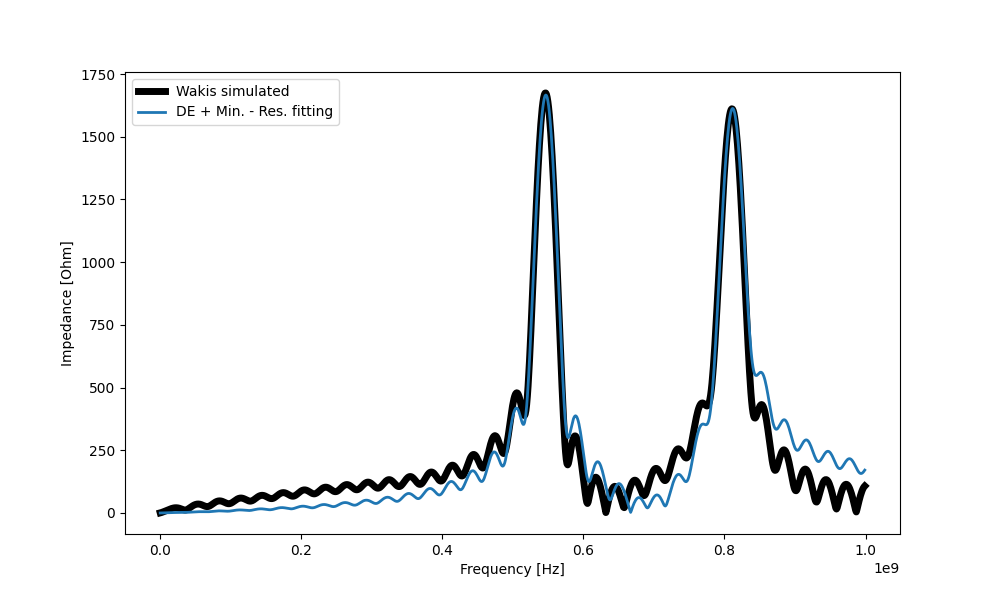

In [17]:
plt.figure(figsize=(10, 6))
DEfitted_wake = np.abs(wake.DE_model.get_impedance_from_fitFunction(wake.f, use_minimization=True))

plt.plot(wake.f, np.abs(wake.Z), lw=5, label='Wakis simulated', color='black')
plt.plot(wake.f, np.abs(DEfitted_wake),  lw=2, label='DE + Min. - Res. fitting')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Impedance [Ohm]')
plt.legend()